# NMF

In [7]:
import numpy as np
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from utils import TFRmEvents, ExcludSubj, ConcatPCA, PlotTimeSerie, OUT_PATH, PlotCompoIndividual, FREQ_BAND
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('seaborn-v0_8-dark')

In [8]:
tfr_path = '/users/barbara/Desktop/MIB_iEEG/outs/Data_shortWOBS'
subj_included = [file.replace('_TFRtrials.p', '') for file in os.listdir(tfr_path) if file[-len('TFRtrials.p'):] == 'TFRtrials.p']
subj_included = ExcludSubj(subj_included, data_path=tfr_path)

/users/barbara/miniforge3/envs/mne_iEEG/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


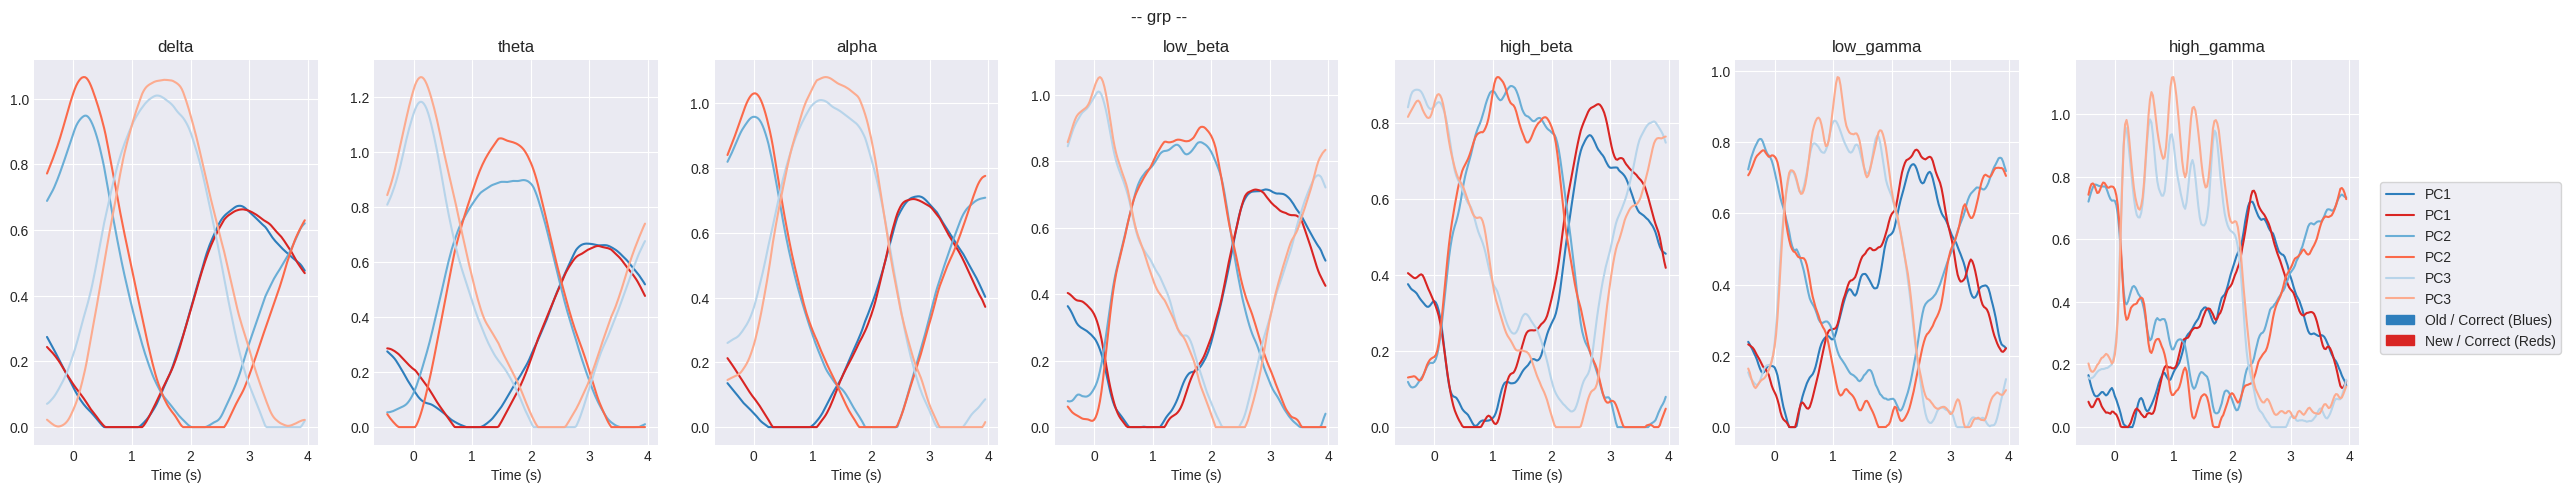

In [9]:
# CONCAT
concat_dict_ = []
for subj in subj_included : 
    TFRm = TFRmEvents(subj, data_path = tfr_path )
    concat_dict_.append(np.concatenate([TFRm[i, :, :,:] for i in [0, 1]], axis = 2))
    
concat_list = []

for subj in subj_included: 
    TFRm = TFRmEvents(subj, data_path = tfr_path)
    #with open(tfr_path + f'/{subj}_info.json') as json_data:
    #    d = json.load(json_data)
    #    time = d['time_tfr']
    #    json_data.close()

    #baseline_end = int(time.index([t for t in time if t>0][0]))
    #mean_baseline = TFRm[:baseline_end].mean(axis=-1, keepdims=True)
    #TFRm_baseline = TFRm-mean_baseline
    TFRm_baseline = TFRm

    concat_list.append(np.concatenate([TFRm_baseline[i, :, :,:] for i in [0, 1]], axis = 2))
concat_all = np.concatenate(concat_list, axis = 0)

df_Componants, df_X_transformed = ConcatPCA({'grp' : concat_all}, ch_id = False, nb_compo=3, method='nmf')
PlotTimeSerie({'grp' : concat_all}, df_X_transformed, out_path = f'{OUT_PATH}/grpNMF/supsubj_concat', save=True, show=True,  data_path = tfr_path)
PlotCompoIndividual('grp', df_Componants, subj_included=subj_included, out_path=f'{OUT_PATH}/grpNMF/supsubj_concat', browser=False, nb_compo=3, method='nmf',  data_path = tfr_path )


In [10]:
# MEAN
mean_list = []
mean_tfr_per_condi  =[]

for subj in subj_included : 
    TFRm = TFRmEvents(subj, data_path=tfr_path)
    # Normalization with baseline  
    #with open(OUT_PATH + f'/Data/{subj}_info.json') as json_data:
        #d = json.load(json_data)
        #time = d['time_tfr']
        #json_data.close()

    #baseline_end = int(time.index([t for t in time if t>0][0]))
    #mean_baseline = TFRm[:baseline_end].mean(axis=-1, keepdims=True)
    #TFRm_baseline = TFRm-mean_baseline

    mean_list.append(np.mean(TFRm[[0, 1], :, :,:], axis = 0))
    mean_tfr_per_condi.append(TFRm)

mean_all = np.concatenate(mean_list, axis = 0)
mean_tfr_per_condi_all = np.concatenate(mean_tfr_per_condi, axis = 1)

df_Componants_mean, df_X_transformed_mean = ConcatPCA({'grp' : mean_all}, ch_id = False, nb_compo=3, method='nmf')
PlotCompoIndividual('grp', df_Componants_mean, subj_included=subj_included, out_path=f'{OUT_PATH}/grpNMF/supsubj_mean', browser=False, nb_compo=3,  method='nmf',  data_path = tfr_path)

out_file = OUT_PATH + '/grpNMF/supsubj_mean'
df_X_transformed_mean.to_csv(out_file + '/grp_mean_Xtrans_NMF3.csv')
df_Componants_mean['grp'].to_csv(out_file + '/grp_mean_compo_NMF3.csv')

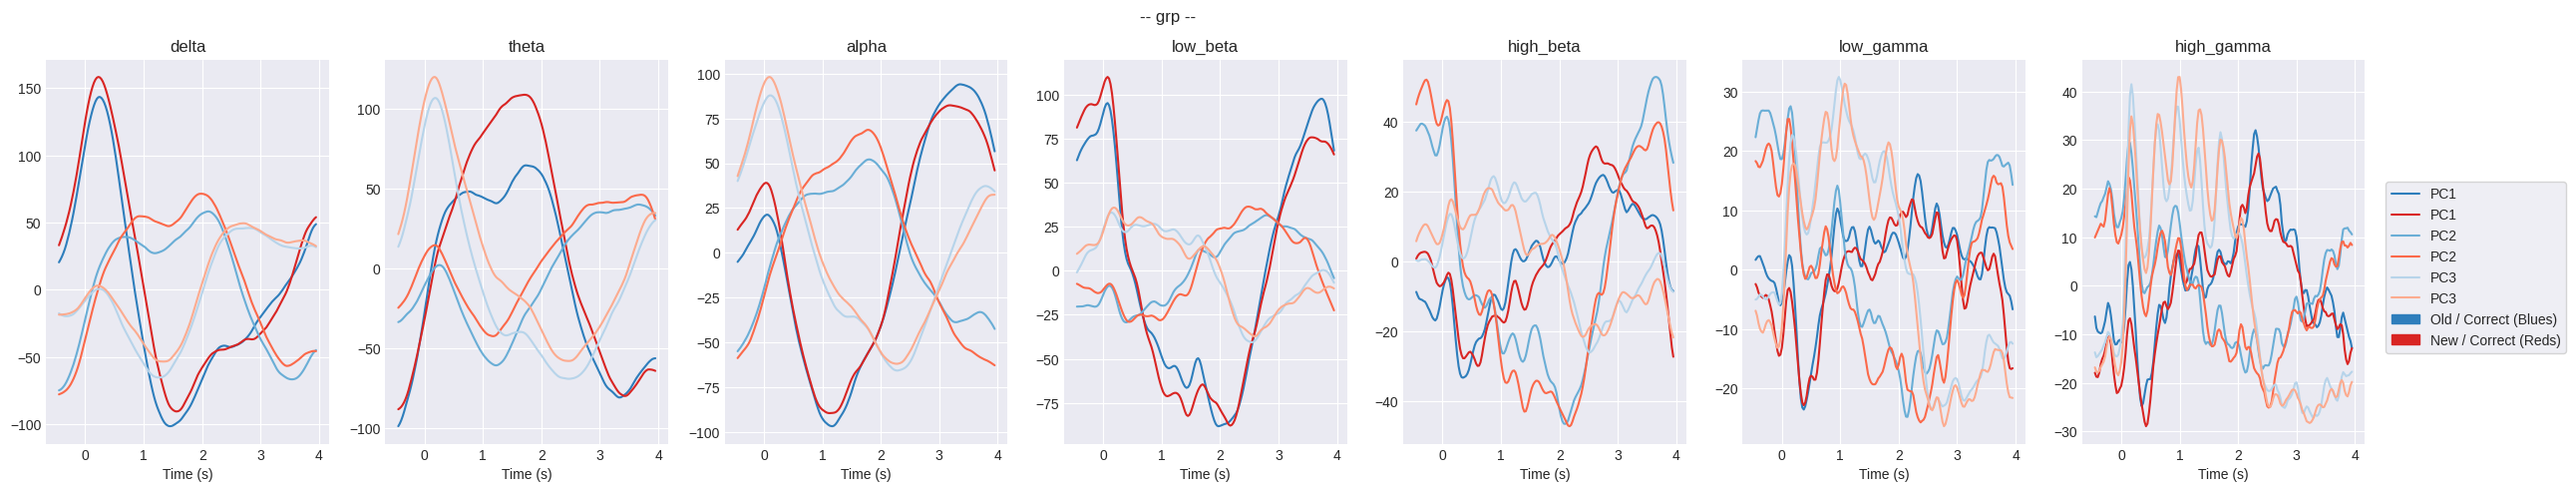

In [12]:
df_list_trans =[]
nb_compo=3
for i_b, band in enumerate(FREQ_BAND): 
    weights = df_Componants_mean['grp'].query('freq == @band').drop(columns = ['compo', 'freq']).values[:nb_compo, :]

    data1 = weights @ mean_tfr_per_condi_all[0,:, i_b, :]
    data2 = weights @ mean_tfr_per_condi_all[1,:, i_b, :]
    df_tr= pd.DataFrame(np.concat([data1, data2], axis = 1))
    df_tr['compo'] = ['compo' + str(i+1) for i in range(nb_compo)]
    df_tr['freq']  = band
    df_tr['subj']  = 'grp'
    df_list_trans.append(df_tr)

PlotTimeSerie({'grp' : mean_all}, pd.concat(df_list_trans), out_path = f'{OUT_PATH}/grpNMF/supsubj_mean', save=True, show=True, data_path=tfr_path)